# Calibrating the ZP of R and r images #

The goal is to bootstrap the zeropoint of our R and r-band images using photometric catalogs from Pan-STARRS.

We are using test images from 2015-04-18 taken with the HDI camera on KPNO 0.9m telescope

Ideally, we will also get the flux calibration for the Halpha image.

If the data were taken through the Johnson R filter, we will need to covert the Pan-STARRS r magnitudes to R.

The transformations from SDSS r to Johnson R are:

$$ R-r   =  (-0.153 ± 0.003)(r-i) - (0.117 \pm 0.003) $$

or 

$$ R   =  r + (-0.153 ± 0.003)(r-i) - (0.117 \pm 0.003) $$

http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Jordi2006

NOTE: This is not the relationship to use to convert from Pan-STARRS r to Johnson R.  See below.








# NOTES #

### Basic Steps For Program getzp.py ###

* Run Source Extractor on image to measure magnitudes
* Read in Source Extractor catalog
* get max/min RA and DEC for the image
* get Pan-STARRS catalog over the same region
* match Pan-STARRS1 data to Source Extractor sources
* remove any objects that are saturated or non-linear in our r-band image
* Solve for the zeropoint


### Data Checks ###
* HDI nonlinearity kicks in by 40k counts
* need to check raw counts of R and Halpha images for the 180 and 20 min exposures
* make sure the sources we are using are not saturated.
* check if units of mosaic are ADU/s



### Improving Code ###
* implemented scipy.optimize.curve_fit in getzp.py to 
    * keep slope fixed at 1
    * this allows us to get an estimate of error in ZP (sqrt(covariance))
    
* now using SExtractor aperture magnitudes rather than MAG_AUTO.  The user can select which aperture number to use using the --naper command line argument.  Right now, in default.sex.HDI, I request aperture magnitudes of  5,10,12,15,20,25 pixel diameter.  The default value for --naper is 4, which corresponds to the 20 pix diameter aperture.  I just realized this is diameter rather than radius, so these values might not be large enough.  I'll wait for the comparison with Becky before exploring this further, but if FWHM is typically 4-5 pixels, then is a 25-pixel diameter aperture large enough?


### AB vs Vega Magnitudes ###

To convert from Vega to AB zeropoint, use conversion from Blanton+2007, which is listed at
http://www.astronomy.ohio-state.edu/~martini/usefuldata.html

$ ZP_{AB} = ZP_{Vega} +.21$

In [15]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline



In [3]:
datadir = '/Users/rfinn/research/HalphaGroups/reduced_data/HDI/20150418'
os.chdir(datadir)


## Comparing with Standard Stars ##

As a test, I want to calibrate the standard star images, and then measure the magnitudes of the standard stars.

I apparently moved a number of the standard star files to junk, so I will need to reduce these images through flatfielding.

I copied all standard files from raw directory:

```
cp ../../../rawdata/20150418/c7131t00{19..25}o00.fits standards_raw/
cp ../../../rawdata/20150418/c7131t00{70..74}o00.fits standards_raw/.
```

The reduction is detailed in the notebook reduction-of-standard-star-images.ipynb




## Checking Magnitudes of Standard Stars ##

From Becky:

```
# FIELD     FILTER  OTIME   AIRMASS  XCENTER   YCENTER  MAG   MERR
PG0918+029A   R   02:40:12     1.151   2071.654  1732.055  15.960  0.013 
PG0918+029B   R   02:40:12     1.151   2151.200  1964.721  15.335  0.008 
PG0918+029C   R   02:40:12     1.151   1819.131  1776.168  14.979  0.006 
PG0918+029D   R   02:40:12     1.151   2537.494  1889.052  13.498  0.002 
PG0918+029    R   02:40:12     1.151   2314.763  1688.586  15.251  0.007 
RU_149A       R   02:43:25     1.308    2172.032  2011.177  16.190  0.016
RU_149B       R   02:43:25     1.308    2018.314  1981.408  14.089  0.003
RU_149C       R   02:43:25     1.308    2028.162  2076.732  16.101  0.015
RU_149D       R   02:43:25     1.308    2095.895  2024.223  13.283  0.002
RU_149E       R   02:43:25     1.308    1991.068  2235.042  15.207  0.007
RU_149F       R   02:43:25     1.308    2143.203  2186.315  14.707  0.005
RU_149G       R   02:43:25     1.308    2218.802  2139.711  14.334  0.004
RU_149        R   02:43:25     1.308    2172.032  2011.177  16.190  0.016
PG1528+062A   R    11:50:34    1.433    2124.965  2059.521  16.876  0.016
PG1528+062B   R    11:50:34    1.433    2459.723  2029.408  13.462  0.002
PG1528+062    R    11:50:34    1.433    2094.694  1993.606  16.689  0.013
PG1633+099A   R    11:53:52    1.18     2016.623  2014.445  16.548  0.008
PG1633+099B   R    11:53:52    1.18     1759.578  1800.097  14.182  0.002
PG1633+099C   R    11:53:52    1.18     1621.906  1790.770  14.410  0.002
PG1633+099D   R    11:53:52    1.18     1524.724  1852.141  15.153  0.003
PG1633+099    R    11:53:52    1.18     2085.292  2005.930  16.285  0.007

```


Becky suggested to focus on Landolt standards only, and to not include the spectrophotometric standards.  She sent the above list, although the positions of the stars in my images are different (not sure why).

* I found the finding charts and V and V-R magnitudes for the landolt standards at

https://www.cfht.hawaii.edu/ObsInfo/Standards/Landolt/

* I then recorded the positions of the stars in the file **mystandards.csv**.

* I wrote another program to pull out the measured photometry for each standard star - **dbug_getzp.py**.  This allows me to make changes in getzp.py and then compare the measured vs known magnitudes of the landolt standards.



In [16]:
os.chdir('/Users/rfinn/research/HalphaGroups/reduced_data/HDI/20150418/standards_raw/')



In [22]:
stand = ascii.read('mystandards.csv', delimiter=',')

In [23]:
print(t)

          IMAGE             STANDARD    V    V-R     R    XIMAGE YIMAGE
------------------------- ----------- ----- ------ ------ ------ ------
nshdztrc7131t0019o00.fits PG0918+029A 14.49  0.325 14.165   2024   1731
nshdztrc7131t0019o00.fits PG0918+029B 13.96  0.417 13.543   1945   1964
nshdztrc7131t0019o00.fits PG0918+029C 13.54  0.367 13.173   2277   1775
nshdztrc7131t0019o00.fits PG0918+029D 12.27  0.575 11.695   1558   1888
nshdztrc7131t0019o00.fits  PG0918+029 13.33 -0.129 13.459   1781   1688
nshdztrc7131t0020o00.fits     RU_149A  14.5  0.196 14.304   1924   2011
nshdztrc7131t0020o00.fits     RU_149B 12.64  0.374 12.266   2078   1981
nshdztrc7131t0020o00.fits     RU_149C 14.43  0.093 14.337   2068   2076
nshdztrc7131t0020o00.fits     RU_149D 11.48  0.021 11.459   2000   2024
nshdztrc7131t0020o00.fits     RU_149E 13.72  0.321 13.399   2105   2234
nshdztrc7131t0020o00.fits     RU_149F 13.47  0.594 12.876   1952   2186
nshdztrc7131t0020o00.fits     RU_149G 12.83  0.322 12.508   1878

## Solving for Zeropoint ##

Now ready to solve for ZP of images.  Going to focus on R-band images first

| Filename | Standard | ZP | SECZ | NPOINTS  | 
|----------|----------|-----|-----|-----------|
|shdztrc7131t0019o00.fits | PG 918 |23.577 | 1.151 | 63 |
| shdztrc7131t0020o00.fits | RU 149 |23.550 | 1.308 | 317 |
| shdztrc7131t0022o00.fits | Feige 34 | 23.641 | 1.1 | 41 |
|shdztrc7131t0072o00.fits| BD+33 | 23.603 | 1.0 | 39 |
|shdztrc7131t0073o00.fits | PG 1528 | 23.546| 1.433 | 99 |
|shdztrc7131t0074o00.fits | PG 1633 |23.578 | 1.18 | 175 |



In [12]:
%run ~/github/HalphaImaging/dbug_getzp.py

# aper mag, but using SDSS transformation from r to R


## SDSS filter transformation doesn't work ##

The SDSS filter transformation leads to a systematic offset of around 0.08 between measured and Landolt magnitudes.


### Trying other magnitudes ###

* I tried using --filter r flag, and this made the offset worse (dm > 0.2 mag).

* I tried aperture magnitudes - 

* I tried switching to petro magnitudes  - this changes the zeropoint, but the final mags are about the same.  The median offset in measured - landolt is around 0.08 mag.

## pan-starrs references ##

* https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=II/349 - details on catalog

* https://arxiv.org/pdf/1612.05242.pdf

* this website says kron radius does not enclose total flux and you should expect 10% of flux to be missing.  this is consistent with what I am measuring, I think?

* https://iopscience.iop.org/article/10.1088/0067-0049/205/2/20

* **Transformation of Pan-STARRS1 gri
to Stetson BVRI magnitudes.
Photometry of small bodies observations.** https://arxiv.org/pdf/1706.06147.pdf 



# updated code to use new conversion from gunn to Johnson filters. #


This was hugely useful!  brought the discrepancy down to < 0.02 mag




However, it seems like the two conversions from r to R (one uses g-r and the other uses r-i) give different zeropoints.

* The r-i relation does not work as well - gives systematic offset in measured - landolt mag of:

$$R_{measured} - R_{landolt} = -0.0833 \pm 0.0286$$

* The g-r relation gives a smaller systematic offset in the measured magnitude:

$$R_{measured} - R_{landolt} = 0.0105 \pm 0.0276$$

* The dispersion is similar for both relationships.

* When using mag_aper number 4 (instead of mag_petro which I used for the above two results), and the g-r relation to convert r to R, I get similar values for the residuals (slightly higher offset):

$$R_{measured} - R_{landolt} = 0.0119 \pm 0.0245 $$

* Ideally, you use the same type of magnitude for fitting the ZP as you do for measuring the magnitudes of the science objects.  However, we are calibrating the ZP using stars, and we plan to measure the magnitudes of galaxies.  Need to figure out the best way to do this. 

* I tested mag_best b/c this is often what we use for measuring galaxy magnitudes.  This is the result:

$$R_{measured} - R_{landolt} = 0.0051 \pm 0.0235 $$



### Getting ZPs using g-r relation ###

Petro magnitudes, g-r conversion from r to R (Kostov & Bonov)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
os.chdir('/Users/rfinn/research/HalphaGroups/reduced_data/HDI/20150418/standards_raw/')


In [11]:
%run ~/github/HalphaImaging/dbug_getzp.py --fitzp


nshdztrc7131t0019o00.fits
saturation limit in ADU/s 5000.0
sex nshdztrc7131t0019o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0019o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5000.0
('number of points retained = ', masked)
new ZP = 0.000, previous ZP = -23.511
('number of points retained = ', 71)
new ZP = -23.511, previous ZP = -23.506
('number of points retained = ', 68)
new ZP = -23.506, previous ZP = -23.495
('number of points retained = ', 64)
new ZP = -23.495, previous ZP = -23.479
('number of points retained = ', 61)
new ZP = -23.479, previous ZP = -23.476
('number of points retained = ', 59)
new ZP = -23.476, previous ZP = -23.477
working on this
nshdztrc7131t0020o00.fits
saturation limit in ADU/s 5714.3
sex nshdztrc7131t0020o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0020o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5714.28571429
('number of points retained = ', masked)
new ZP = 0.000, previous ZP = -24.001
('number of points retained = ', 388)
new ZP = -24.001, previous Z

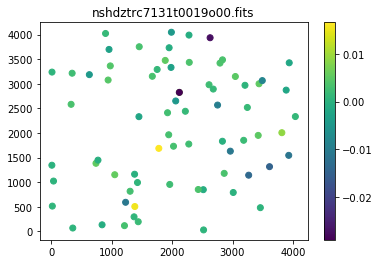

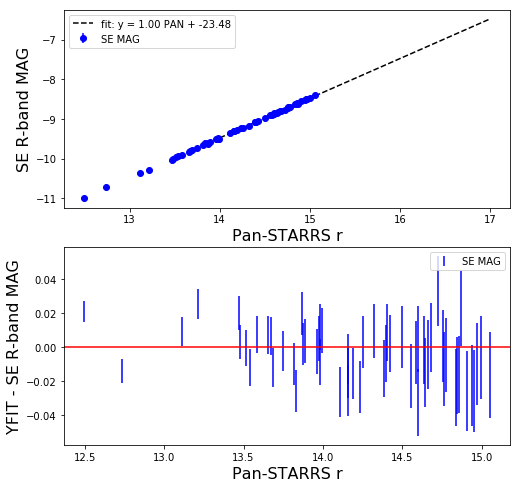

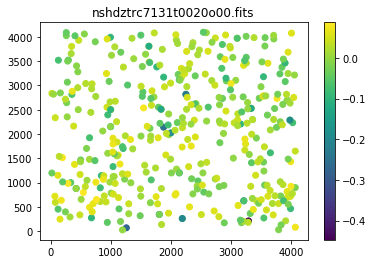

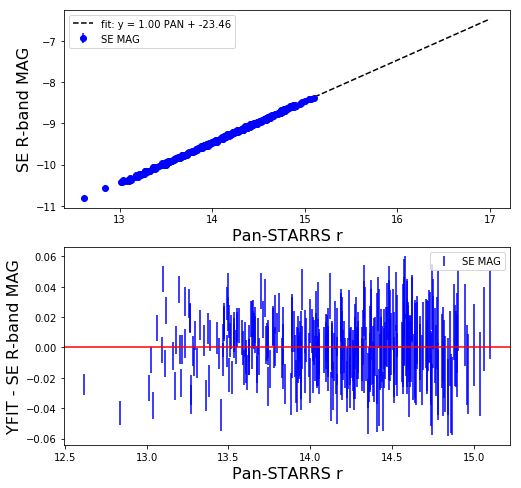

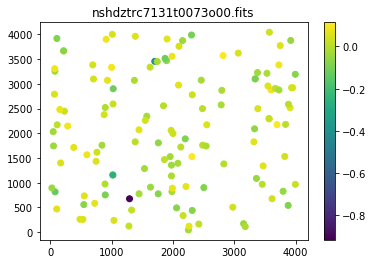

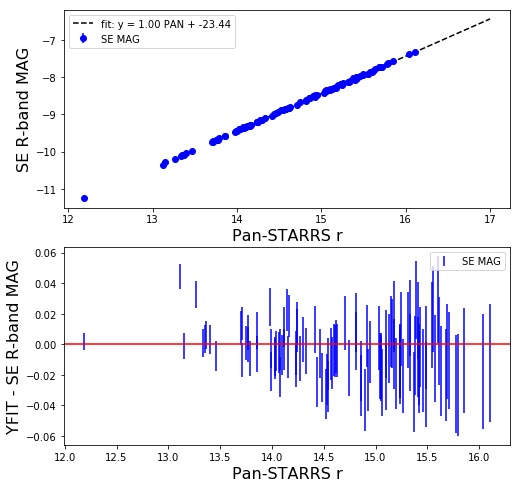

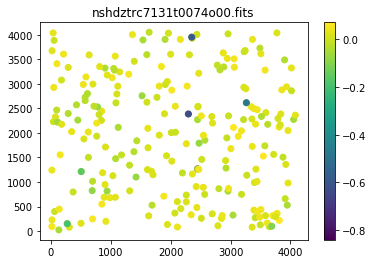

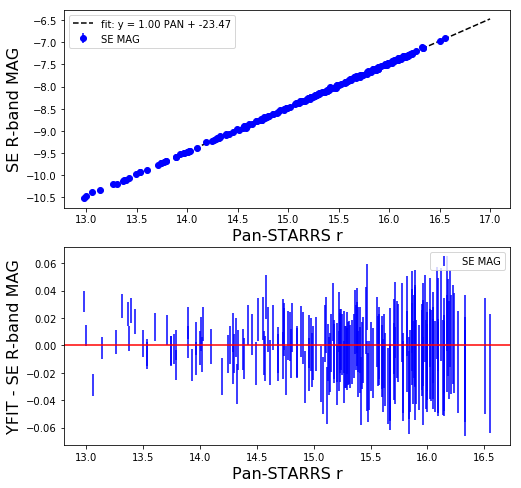

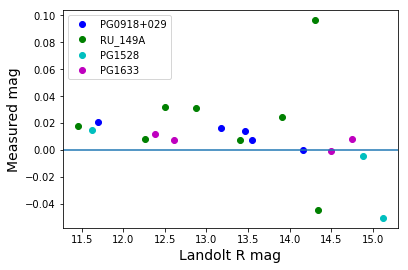

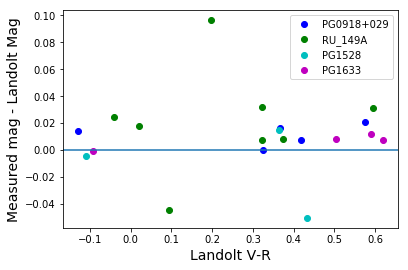

In [12]:
plt.show()

In [13]:
print(np.mean(residual),np.std(residual))

(0.010512596130371185, 0.027648397871649272)


### Using r-i conversion ###

Petro magnitudes, r-i conversion from r to R (Kostov & Bonov)

In [4]:
%run ~/github/HalphaImaging/dbug_getzp.py --fitzp --useri

nshdztrc7131t0019o00.fits
saturation limit in ADU/s 5000.0
sex nshdztrc7131t0019o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0019o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5000.0
('number of points retained = ', masked)
new ZP = 0.000, previous ZP = -23.471
('number of points retained = ', 71)
new ZP = -23.471, previous ZP = -23.406
('number of points retained = ', 69)
new ZP = -23.406, previous ZP = -23.395
('number of points retained = ', 65)
new ZP = -23.395, previous ZP = -23.379
('number of points retained = ', 63)
new ZP = -23.379, previous ZP = -23.375
('number of points retained = ', 63)
new ZP = -23.375, previous ZP = -23.375
working on this
nshdztrc7131t0020o00.fits
saturation limit in ADU/s 5714.3
sex nshdztrc7131t0020o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0020o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5714.28571429
('number of points retained = ', masked)
new ZP = 0.000, previous ZP = -23.896
('number of points retained = ', 388)
new ZP = -23.896, previous Z

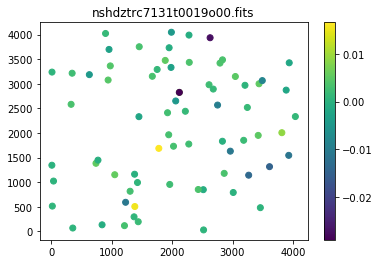

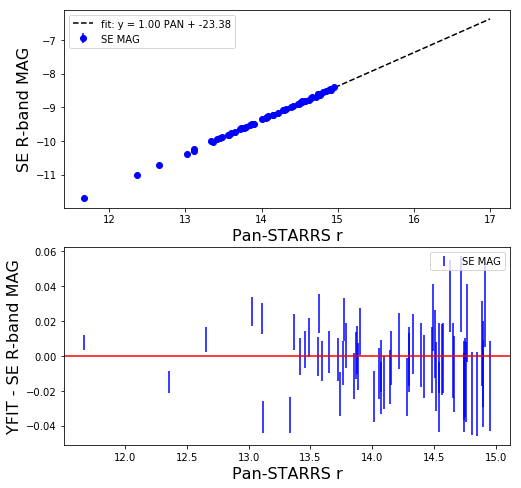

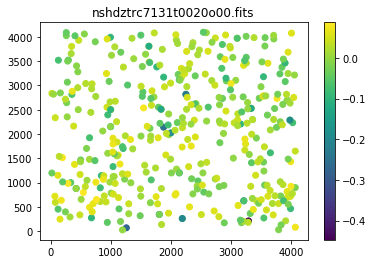

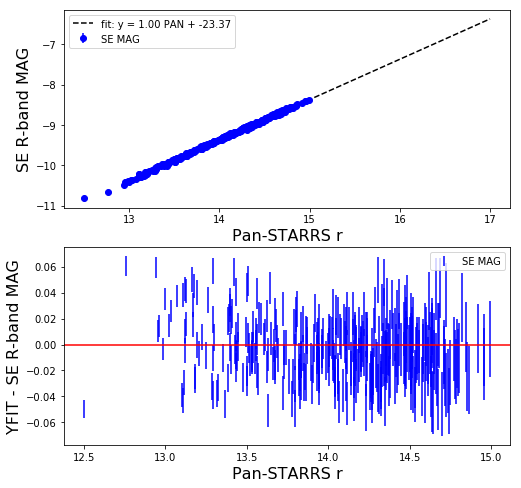

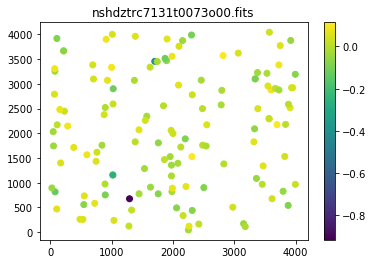

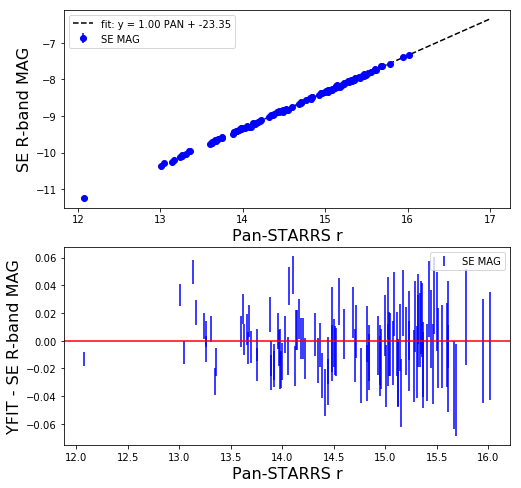

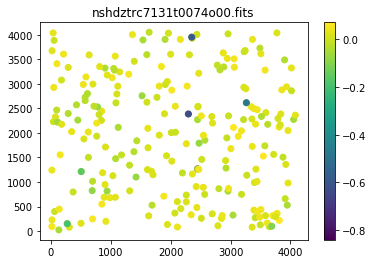

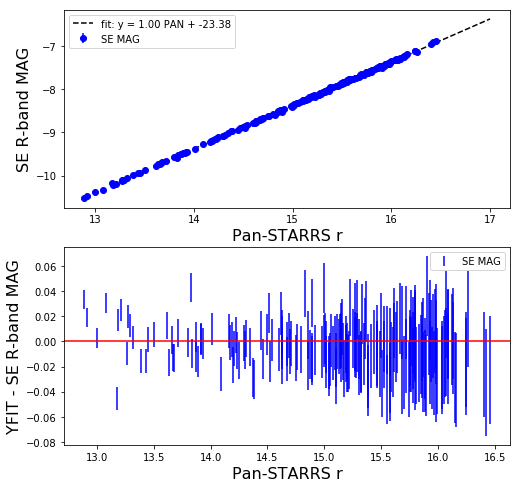

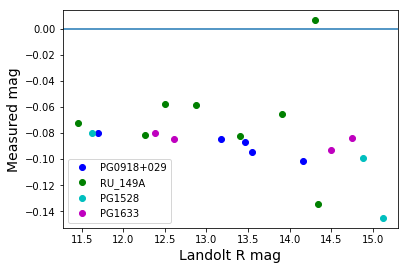

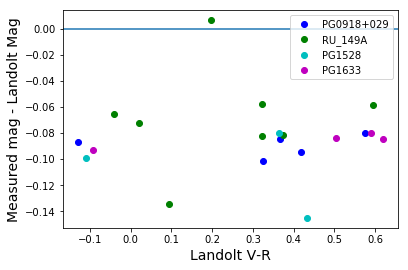

In [5]:
plt.show()

In [10]:
print(np.mean(residual),np.std(residual))

(-0.083295350937616169, 0.028574837848460658)


## Checking aperture mag vs petro mag ##

* Now we know to stick with g-r relation.  How does the choice of magnitude affect the ZP and offsets between measured and landolt magnitude?
* Have to change magnitude choice in getzp and in dbug zp, unless I make this an option to pass in...

* need to restart kernal after each change in getzp.py, so this argues in favor of making the type of magnitude an option.  Choices could be:
    * MAG_BEST
    * MAG_APER (with naper specified)
    * MAG_PETRO?


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
os.chdir('/Users/rfinn/research/HalphaGroups/reduced_data/HDI/20150418/standards_raw/')


In [2]:
# using mag_aper, number naper=4, in each
%run ~/github/HalphaImaging/dbug_getzp.py --fitzp

//anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


nshdztrc7131t0019o00.fits
saturation limit in ADU/s 5000.0
sex nshdztrc7131t0019o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0019o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5000.0


//anaconda/lib/python2.7/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


('number of points retained = ', masked)
new ZP = 0.000, previous ZP = -23.536
('number of points retained = ', 71)
new ZP = -23.536, previous ZP = -23.531
('number of points retained = ', 68)
new ZP = -23.531, previous ZP = -23.519
('number of points retained = ', 64)
new ZP = -23.519, previous ZP = -23.500
('number of points retained = ', 62)
new ZP = -23.500, previous ZP = -23.494
('number of points retained = ', 61)
new ZP = -23.494, previous ZP = -23.497
('number of points retained = ', 59)
new ZP = -23.497, previous ZP = -23.497
working on this


/Users/rfinn/github/HalphaImaging/getzp.py:236: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if yerr == None:
/Users/rfinn/github/HalphaImaging/getzp.py:251: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if yerr == None:


nshdztrc7131t0020o00.fits
saturation limit in ADU/s 5714.3
sex nshdztrc7131t0020o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0020o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5714.28571429
('number of points retained = ', masked)
new ZP = 0.000, previous ZP = -24.029
('number of points retained = ', 388)
new ZP = -24.029, previous ZP = -23.635
('number of points retained = ', 383)
new ZP = -23.635, previous ZP = -23.525
('number of points retained = ', 370)
new ZP = -23.525, previous ZP = -23.488
('number of points retained = ', 355)
new ZP = -23.488, previous ZP = -23.477
('number of points retained = ', 346)
new ZP = -23.477, previous ZP = -23.474
('number of points retained = ', 337)
new ZP = -23.474, previous ZP = -23.471
('number of points retained = ', 330)
new ZP = -23.471, previous ZP = -23.470
('number of points retained = ', 327)
new ZP = -23.470, previous ZP = -23.470
working on this
nshdztrc7131t0073o00.fits
saturation limit in ADU/s 5714.3
sex nshdztrc7131t0073o00.fits -

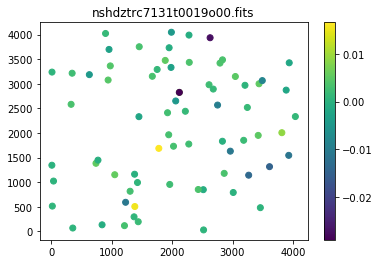

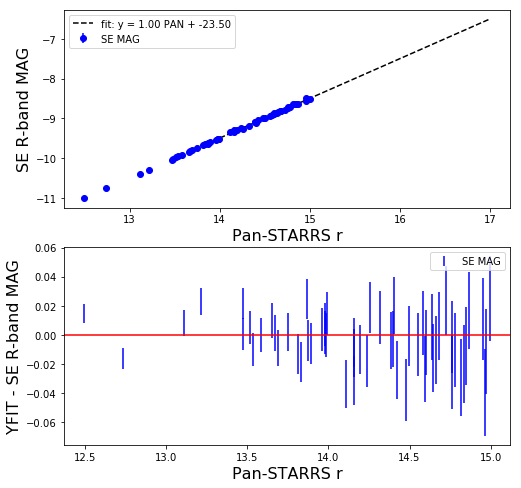

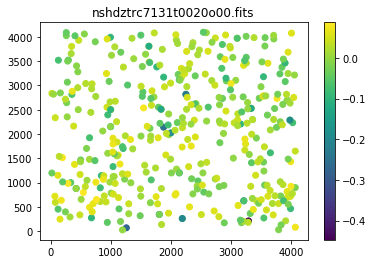

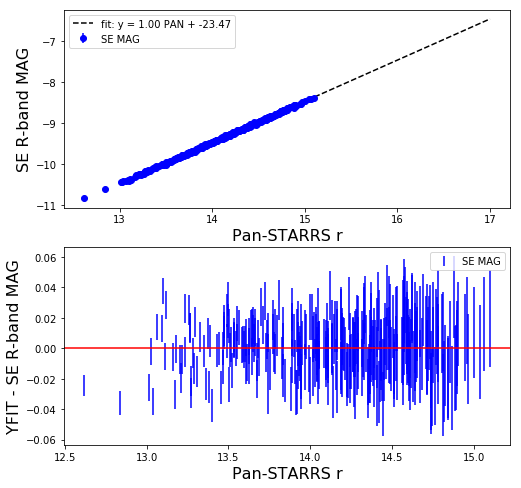

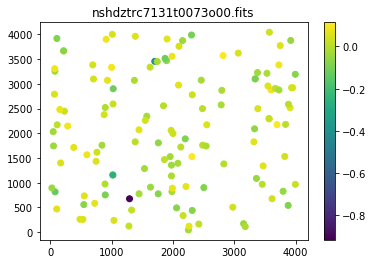

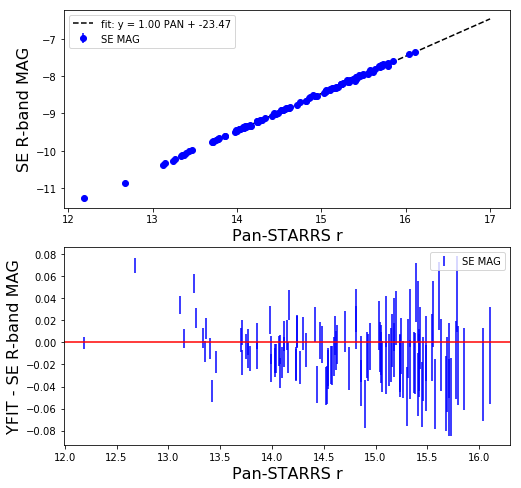

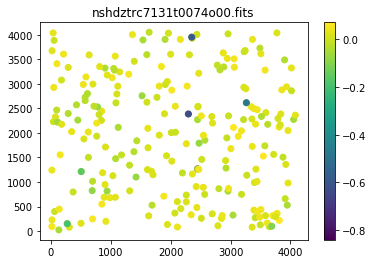

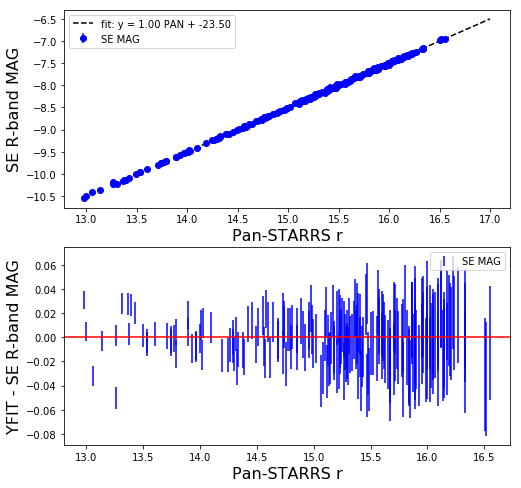

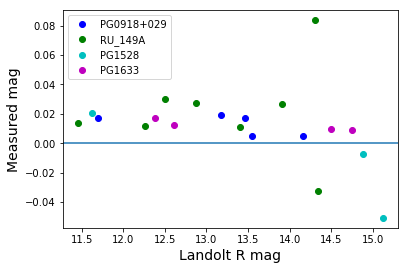

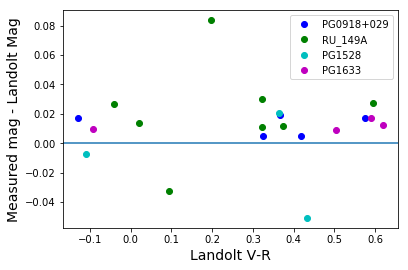

In [3]:
plt.show()

In [4]:
print(np.mean(residual),np.std(residual))

(0.011931981404622488, 0.024452707686025664)


## Trying MAG_BEST ##

this is what we will use to measure galaxy magnitudes, probably.  A

Although we are also measuring flux in elliptical apertures, so maybe that argues for the aperture magnitudes?

Anyway, trying MAG_BEST to see if the residuals and scatter are similar.


Again, need to restart kernal after setting magnitude to MAG_BEST in both getzp.py and dbug_getzp.py


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
os.chdir('/Users/rfinn/research/HalphaGroups/reduced_data/HDI/20150418/standards_raw/')


In [5]:
# using mag_best, in each
%run ~/github/HalphaImaging/dbug_getzp.py --fitzp

nshdztrc7131t0019o00.fits
saturation limit in ADU/s 5000.0
sex nshdztrc7131t0019o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0019o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5000.0
('number of points retained = ', masked)
new ZP = 0.000, previous ZP = -23.486
('number of points retained = ', 71)
new ZP = -23.486, previous ZP = -23.480
('number of points retained = ', 68)
new ZP = -23.480, previous ZP = -23.469
('number of points retained = ', 65)
new ZP = -23.469, previous ZP = -23.436
('number of points retained = ', 62)
new ZP = -23.436, previous ZP = -23.443
('number of points retained = ', 60)
new ZP = -23.443, previous ZP = -23.446
('number of points retained = ', 58)
new ZP = -23.446, previous ZP = -23.446
working on this
nshdztrc7131t0020o00.fits
saturation limit in ADU/s 5714.3
sex nshdztrc7131t0020o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0020o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5714.28571429
('number of points retained = ', masked)
new ZP = 0.000, previous ZP

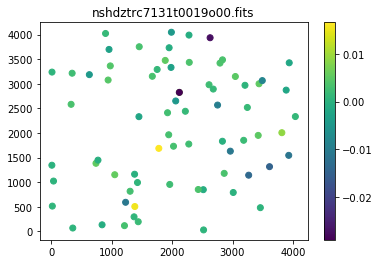

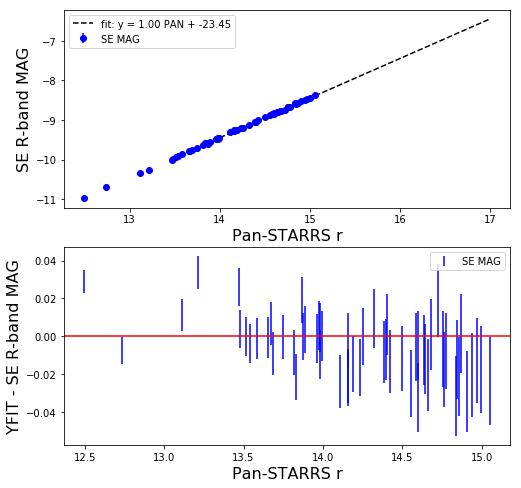

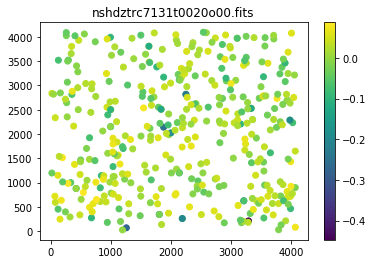

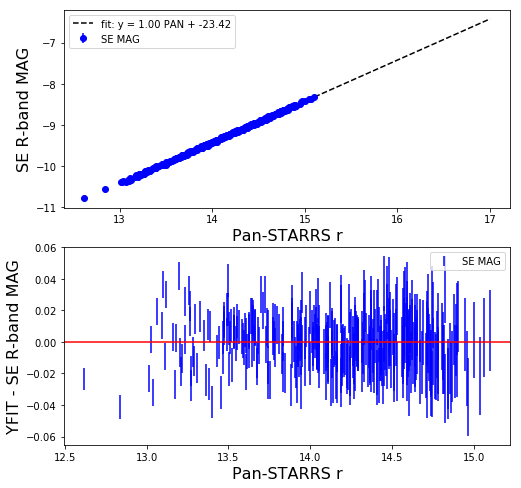

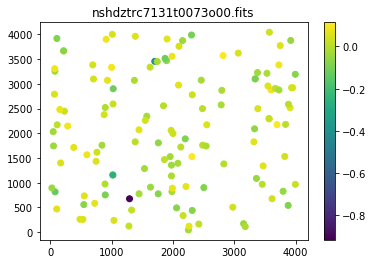

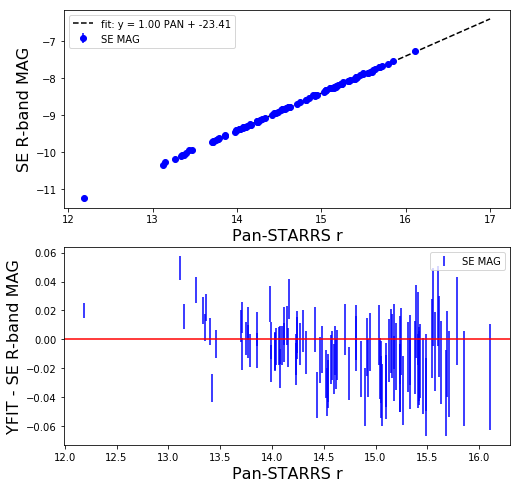

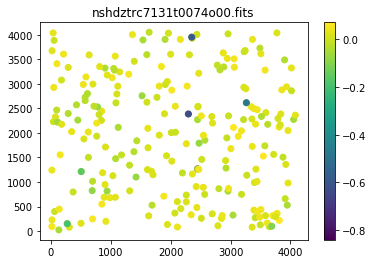

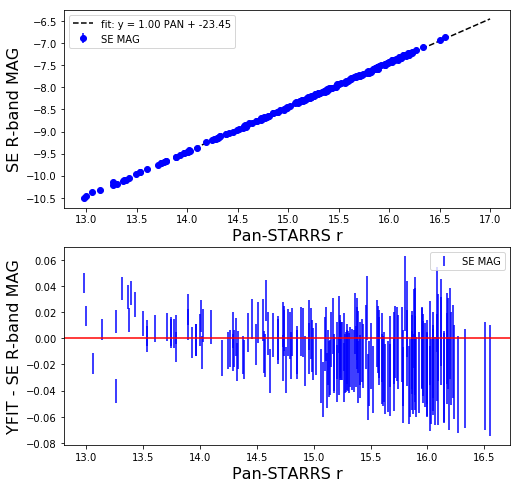

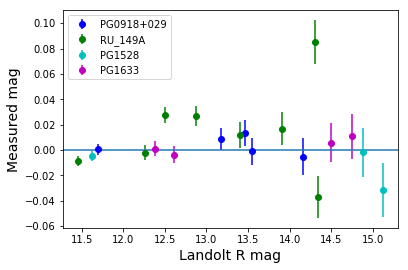

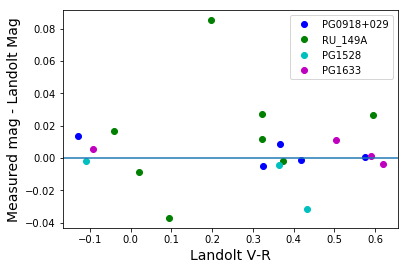

In [6]:
plt.show()

In [7]:
print(np.mean(residual),np.std(residual))

(0.0050524473644439167, 0.023502794280407587)


In [9]:
zpdict

{'nshdztrc7131t0019o00.fits': 23.446201,
 'nshdztrc7131t0020o00.fits': 23.421856,
 'nshdztrc7131t0073o00.fits': 23.410093,
 'nshdztrc7131t0074o00.fits': 23.449709}

# Summary #

* New calibration from r to R using g-r colors by Kostov & Bonov allows us to recover magnitudes of landolt standards with the following accuracy:  
$$R_{measured} - R_{landolt} = 0.0105 \pm 0.0276~~ (MAG\_PETRO)$$
$$R_{measured} - R_{landolt} = 0.0119 \pm 0.0245 ~~ (MAG\_APER4)$$
$$R_{measured} - R_{landolt} = 0.0051 \pm 0.0235 ~~ (MAG\_BEST)$$


* Both MAG_PETRO and MAG_APER ($R = 10 pix$) yield similar results in terms of the mean and std of the residuals.  


* MAG_BEST has the smallest mean of residuals, but std of residuals is comparable to MAG_PETRO and MAG_APER.


* ZPs are different

|Image |MAG_PETRO | MAG_APER4 | MAG_BEST |
|------|----------|----------|----------|
|nshdztrc7131t0019o00.fits|23.477|23.497| 23.446|
|nshdztrc7131t0020o00.fits|23.461|23.470| 23.423|
|nshdztrc7131t0073o00.fits|23.441|23.466| 23.410|
|nshdztrc7131t0074o00.fits|23.471|23.500| 23.450|

* We need to figure out which is the most relevant ZP to use when measuring elliptical aperture photometry of galaxies.
